# 1. Intro to the Dataset and the Aim
\<img src="/jamboree_logo.png" alt="jamboree logo banner" style="width: 800px;"/>

Jamboree has helped thousands of students like you make it to top colleges abroad. Be it GMAT, GRE or SAT, their unique problem-solving methods ensure maximum scores with minimum effort.

Jamboree team wants to know what factors are important for a students success in getting into an IVY league college. They also want to see if we can make a predictive model to predict the chance of admission to IVY league college using the given features.

**Dataset**

This dataset contains the details of 500 students who have applied for admission to IVY league college along with their success rate.

Summary of sanitized data:
| Column              | Description         | Data Type  |
|---------------------|---------------------|------------|
| `serial_no`         | Unique row ID       | `int64`    |
| `gre_score`         | out of 340          | `int64`    |
| `toefl_score`       | out of 120          | `int64`    |
| `university_rating` | out of 5            | `category` |
| `sop`               | out of 5            | `category` |
| `lor`               | out of 5            | `category` |
| `cgpa`              | out of 10           | `category` |
| `research`          | either 0 or 1       | `category` |
| `chance_of_admit`   | ranging from 0 to 1 | `float64`  |

Additional feature engineered columns:

| Column | Description | Expected Data Type |
|--------|-------------|--------------------|
| `GRE`  | out of 340  | `int64`            |

**Aim:** 
1. To anlyze what factors are important for a students success in getting into an IVY league college.
2. To make a predictive model to predict the chance of admission (`chance_of_admit`) to IVY league college using the given features.

**Methods and Techniques used:** EDA, feature engineering, modeling using sklearn pipelines, hyperparameter tuning

**Measure of Performance and Minimum Threshold to reach the business objective** : RMSE of 5% or less

**Assumptions**
1. This fairly small dataset (500 entries) is representative of the real world population.
2. The data is stable and does not change over time. Thus model assumed to not decay. 

## 1.1 Library Setup

In [53]:
# Scientific libraries
import numpy as np
import pandas as pd

# Logging
import logging

# Visual libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Helper libraries
import urllib.request
from tqdm.notebook import tqdm, trange # Progress bar
#from colorama import Fore, Back, Style # coloured text in output
import warnings 
#warnings.filterwarnings('ignore') # ignore all warkings

# Visual setup
%config InlineBackend.figure_format = 'retina' # sets the figure format to 'retina' for high-resolution displays.

# display estimators as diagrams
from sklearn import set_config
set_config(display='diagram')


# Pandas options
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all' # display all interaction 

# Table styles
table_styles = {
    'cerulean_palette': [
        dict(selector="th", props=[("color", "#FFFFFF"), ("background", "#004D80")]),
        dict(selector="td", props=[("color", "#333333")]),
        dict(selector="table", props=[("font-family", 'Arial'), ("border-collapse", "collapse")]),
        dict(selector='tr:nth-child(even)', props=[('background', '#D3EEFF')]),
        dict(selector='tr:nth-child(odd)', props=[('background', '#FFFFFF')]),
        dict(selector="th", props=[("border", "1px solid #0070BA")]),
        dict(selector="td", props=[("border", "1px solid #0070BA")]),
        dict(selector="tr:hover", props=[("background", "#80D0FF")]),
        dict(selector="tr", props=[("transition", "background 0.5s ease")]),
        dict(selector="th:hover", props=[("font-size", "1.07rem")]),
        dict(selector="th", props=[("transition", "font-size 0.5s ease-in-out")]),
        dict(selector="td:hover", props=[('font-size', '1.07rem'),('font-weight', 'bold')]),
        dict(selector="td", props=[("transition", "font-size 0.5s ease-in-out")])
    ]
}

#from rich import print # color from print statement 
# Seed value for numpy.random => makes notebooks stable across runs
np.random.seed(42)

# Data Collection

## Data Ingestion

In [54]:
class DataIngestor:
    """"
    A class to handle downloading data and loading it into a pandas dataframe along with basic sanity options
    """
    def __init__(self, file_path : str = '../data/raw', url : str = None, output_path : str = '../data/processed/processed.csv'):
        if (url is None and file_path == 'data/raw') or (url is not None and file_path != '../data/raw'):
            raise ValueError('Either url or file_path must/only be specified')
        self.file_path = f"{file_path}"+f"/{url.split('/')[-1]}" if url is not None else file_path # save non default user specified path
        self.url = url
        self.output_path = output_path
    
    def download_data(self) -> None:
        logging.info(f'Downloading data from {self.url}')
        urllib.request.urlretrieve(self.url, self.file_path)

    def load_data(self) -> pd.DataFrame:
        logging.info(f'Ingesting data from {self.file_path}')
        #TODO add csv check
        return pd.read_csv(self.file_path)
    
    def save_data(self, df : pd.DataFrame) -> None:
        logging.info(f'Saving data to {self.output_path}')
        df.to_csv(self.output_path)
        
    def sanitize(self, df : pd.DataFrame) -> pd.DataFrame:
        """
        Rename columns to snake case and strip whitespace
        """
        return df.rename(lambda x: x.lower().strip().replace(' ', '_'),axis='columns')

In [55]:
data_url = DataIngestor(url = 'https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/839/original/Jamboree_Admission.csv')

data_url.download_data()
df = data_url.sanitize(data_url.load_data())

In [56]:
df
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   serial_no.         500 non-null    int64  
 1   gre_score          500 non-null    int64  
 2   toefl_score        500 non-null    int64  
 3   university_rating  500 non-null    int64  
 4   sop                500 non-null    float64
 5   lor                500 non-null    float64
 6   cgpa               500 non-null    float64
 7   research           500 non-null    int64  
 8   chance_of_admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


,serial_no.,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


# Data Wrangling

**Data Integrity and Consistency**
- [x] Uniformity Constraint: All data should be in the same unit or format like date, currency, scales.
    - Example: Convert all date columns to a consistent format (e.g., 'YYYY-MM-DD').
    -  Remove symbols like % or $ 
    -  Remove scaling like 10 means 10k rupees
- [x] Data Type Constraint: Constrain each variable to a specific data type, and check for mixed data types within a column.
    - Example: Convert a column with mixed integers and strings to a consistent data type.
- [x] Data Range Constraints: Each variable could have a limited range like date < current date.
    - Example: Check if all birth dates are before the current date.
- [x] Uniqueness Constraint: Duplicate entries should not be there either complete row or multiple values for the same primary key => take groupby and average.
    - Example: Check for duplicate customer IDs if there are multiple different income value / credit score then average it out 
- [x] Text Constraint: Text should be in the expected format for that variable like phone numbers and emails following patterns and fixed lengths.
    - Example: Check if all email addresses follow the pattern `name@domain.com`.
    - Removing special characters, trimming whitespaces, and handling inconsistent capitalizations.
	- Encoding Issues: Check for consistent encoding (e.g., UTF-8, ASCII) across text data.
	    - Example: Convert all text columns to UTF-8 encoding.
- [x] Categorical Constraint and order: 
    - Uncollapsed categories with the same or similar names
    - Rename and Specify order of category data types

**Data Validation and Relationships**

- [ ] Cross-Field Validation: Compare multiple variables to get cross-field validation like delivery date >= purchase date.
    - Example: Check if the delivery date is always greater than or equal to the purchase date.

- [ ] Referential Integrity: Validate foreign key relationships between tables or datasets.
    - Example: Check if all order IDs in the orders table have a corresponding customer ID in the customers table.
- [ ] Business Rules: Check for any specific business rules or domain-specific constraints that the data should adhere to.
    - Example: In a retail dataset, check if the total order value is equal to the sum of item prices.
- [ ] **Hierarchical Validation**: Validate the hierarchical relationships within the data, such as ensuring that a subcategory belongs to the correct main category.
	- Example: Check if all 'product_subcategory' values correctly correspond to their 'product_category' values.

In [57]:
# # -ve testing
# df.iloc[0,1] = 4
# df.iloc[2,2] = 4322
# df.iloc[3:5] = 2423

class DataWrangler:
    """"
    A class to handle cleaning and wrangling data
    """
    def __init__(self, df : pd.DataFrame):
        self.df = df
        self.processed_df = pd.DataFrame()
        
        # Range constrain attributes
        self.range_constrains = {}
        self.failed_index_range_constrains = pd.Index([])
        
        # Data type constrain attributes
        self.data_type_map = {}
        
        # Unique constrain attributes
        self.unique_cols = []
        self.failed_unique_cols = pd.Index([])
        
    
    def set_data_type(self, data_type_map : dict) -> pd.DataFrame:
        self.data_type_map = data_type_map
        self.processed_df = self.df.astype(data_type_map)
        return self.processed_df
    
    def check_range_constrain(self, constrains : dict) -> bool:
        self.range_constrains = constrains
        mask = np.array([False]*len(self.df))
        for col,(min_range, max_range) in self.range_constrains.items(): 
            mask += (self.df[col] < min_range) | (self.df[col] > max_range)
        self.failed_index_range_constrains = self.df[mask].index
        if mask.any():
            print('Range constrain failed for below rows:')
            print(self.df.iloc[self.failed_index_range_constrains])
            return False
        else : return True
    
    def fix_range_constrain(self) -> pd.DataFrame:
        logging.info(f'Removing entreis for fixing range constrain for {self.failed_index_range_constrains}')
        self.processed_df = self.processed_df.drop(self.failed_index_range_constrains,errors='ignore')
        return self.processed_df
    
    def check_unique(self, unique_cols : list) -> bool:
        self.unique_cols = unique_cols
        mask = np.array([False]*len(self.df))
        for col in unique_cols:
            mask += self.df[col].duplicated()
        self.failed_unique_cols = self.df[mask].index
        if mask.any():
            print('Unique constrain failed for below rows:')
            print(self.df.iloc[self.failed_unique_cols])
            return False
        else : return True
    
    def fix_unique(self) -> pd.DataFrame:
        # TODO add an option to average the non categorical values based on unique columns using groupby 
        logging.info(f'Removing entreis for fixing unique constrain for {self.failed_unique_cols}')
        self.processed_df = self.processed_df.drop(self.failed_unique_cols,errors='ignore')
        return self.processed_df
    
    def set_categorical_order(self, order : dict) -> pd.DataFrame:
        if self.data_type_map is None:
            raise Exception('Please set data type first')
        self.set_categorical_order = order
        for col, order in self.set_categorical_order.items():
            self.processed_df[col] = self.processed_df[col].cat.set_categories(order, ordered=True)
        return self.processed_df 


In [58]:
range_constrains = {
    'gre_score': [0, 340],
    'toefl_score': [0, 120],
    'university_rating': [0, 5],
    'sop': [0, 5],
    'lor': [0, 5],
    'cgpa': [0, 10],
    'research': [0, 1],
    'chance_of_admit': [0, 1]
}

data_type_map = {
    'serial_no.': 'int32',
    'gre_score': 'int32',
    'toefl_score': 'int32',
    'university_rating': 'category',
    'sop': 'category',
    'lor': 'category',
    'cgpa': 'float32',
    'research': 'category',
    'chance_of_admit': 'float32'
}

unique_cols = ['serial_no.']

categorical_order = {
    'university_rating': [1, 2, 3, 4, 5],
    'sop': [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],
    'lor': [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],
    'research': [0, 1]
}

clean_data = DataWrangler(df)
clean_data.set_data_type(data_type_map)

# Check range constrains
if not clean_data.check_range_constrain(range_constrains):
    clean_data.fix_range_constrain()

# Check unique constrain
if not clean_data.check_unique(unique_cols):
    clean_data.fix_unique()

# set categorical order
clean_data.set_categorical_order(categorical_order)

cleaned_df = clean_data.processed_df
data_url.save_data(cleaned_df)

## Final data after wrangling

In [59]:
cleaned_df.info()
display(cleaned_df.describe().style.set_table_styles(table_styles['cerulean_palette']).set_caption("Jamboree data"))
display(cleaned_df.head(10).style.set_table_styles(table_styles['cerulean_palette']).set_caption("Jamboree data after cleaning"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   serial_no.         500 non-null    int32   
 1   gre_score          500 non-null    int32   
 2   toefl_score        500 non-null    int32   
 3   university_rating  500 non-null    category
 4   sop                500 non-null    category
 5   lor                500 non-null    category
 6   cgpa               500 non-null    float32 
 7   research           500 non-null    category
 8   chance_of_admit    500 non-null    float32 
dtypes: category(4), float32(2), int32(3)
memory usage: 12.9 KB


,serial_no.,gre_score,toefl_score,cgpa,chance_of_admit
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,316.472000,107.192000,8.576440,0.721740
std,144.481833,11.295148,6.081868,0.604813,0.141140
min,1.000000,290.000000,92.000000,6.800000,0.340000
25%,125.750000,308.000000,103.000000,8.127500,0.630000
50%,250.500000,317.000000,107.000000,8.560000,0.720000
75%,375.250000,325.000000,112.000000,9.040000,0.820000
max,500.000000,340.000000,120.000000,9.920000,0.970000


,serial_no.,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
0,1,337,118,4,4.500000,4.500000,9.650000,1,0.920000
1,2,324,107,4,4.000000,4.500000,8.870000,1,0.760000
2,3,316,104,3,3.000000,3.500000,8.000000,1,0.720000
3,4,322,110,3,3.500000,2.500000,8.670000,1,0.800000
4,5,314,103,2,2.000000,3.000000,8.210000,0,0.650000
5,6,330,115,5,4.500000,3.000000,9.340000,1,0.900000
6,7,321,109,3,3.000000,4.000000,8.200000,1,0.750000
7,8,308,101,2,3.000000,4.000000,7.900000,0,0.680000
8,9,302,102,1,2.000000,1.500000,8.000000,0,0.500000
9,10,323,108,3,3.500000,3.000000,8.600000,0,0.450000


# Train Test data splitting 
Separate the test data after before visualisation to avoid data snooping bias
* Note to set random seed so that train and test won't get mixed in subsequent runs
* Use a hash function in case if online training and new data is added. This is to ensure that old test data is not mixed with new training data
* If your dataset is not large enough (especially relative to the number of attributes), then you run the risk of introducing a significant sampling bias while doing random sampling => use stratified sampling
	* Find the primary predictor from business
	* Split the data into that predictor categories (strata)  such that each strata is not too small
	* Split using sklearn 

In [60]:
from sklearn.model_selection import train_test_split
X = cleaned_df.drop('chance_of_admit', axis=1)
y = cleaned_df['chance_of_admit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify= cleaned_df['university_rating'])

# Pipeline I : Stationary Pipeline
* Those which can be applied to both predictor and target variable (separately)

# Handling Outliers and Missing Values
* No outliers or missing values in the dataset


- Handling Outliers:  (to be done before missing value imputation to remove effect of outliers)
	- Remove outliers: In some cases, it may be appropriate to simply remove the observations that contain outliers. This can be particularly useful if you have a large number of observations and the outliers are not true representatives of the underlying population.
	- Transform outliers: The impact of outliers can be reduced or eliminated by transforming the feature. For example, a log transformation of a feature can reduce the skewness in the data, reducing the impact of outliers.
	- Impute outliers: In this case, outliers are simply considered as missing values. You can employ various imputation techniques for missing values, such as mean, median, mode, nearest neighbor, etc., to impute the values for outliers.
	- Use robust statistical methods: Some of the statistical methods are less sensitive to outliers and can provide more reliable results when outliers are present in the data. For example, we can use median and IQR for the statistical analysis as they are not affected by the outlier’s presence. This way we can minimize the impact of outliers in statistical analysis.
	- Use discretization or binning : converting numerical variables to categorical form can result in some loss of information, as the precise numerical values within each bin are no longer distinguished thus quality will be reduced thus accuracy of ML model but good for EDA
	  Use Freedman-Diaconis rule to get bin size (same is used by sns when you give bins=n) [numpy implementation](https://medium.com/@maxmarkovvision/optimal-number-of-bins-for-histograms-3d7c48086fde) 
    - Example: Identify and remove salary values that are more than 3 standard deviations away from the mean, but are these all pertaining to a specific role ? then it might be a feature for that 
- Handling Missing Data: Impute using mean or mode with or without grouping by other categories, and check for patterns in missingness.
    - Example: Impute missing values in the 'age' column with the mean age grouped by 'gender'.
    - Check category wise missing 
	- MCAR, MAR, MNAR
	- For sting data type there could be entries like ' ' or 'unknown' like that which are essentially like a missing value (not an issue for category because we can catch it when we take value_counts())
	- Use sklearn methods like `SimpleImputer`, `KNNImputer` or `IterativeImputer` with `add_indicator=True` param


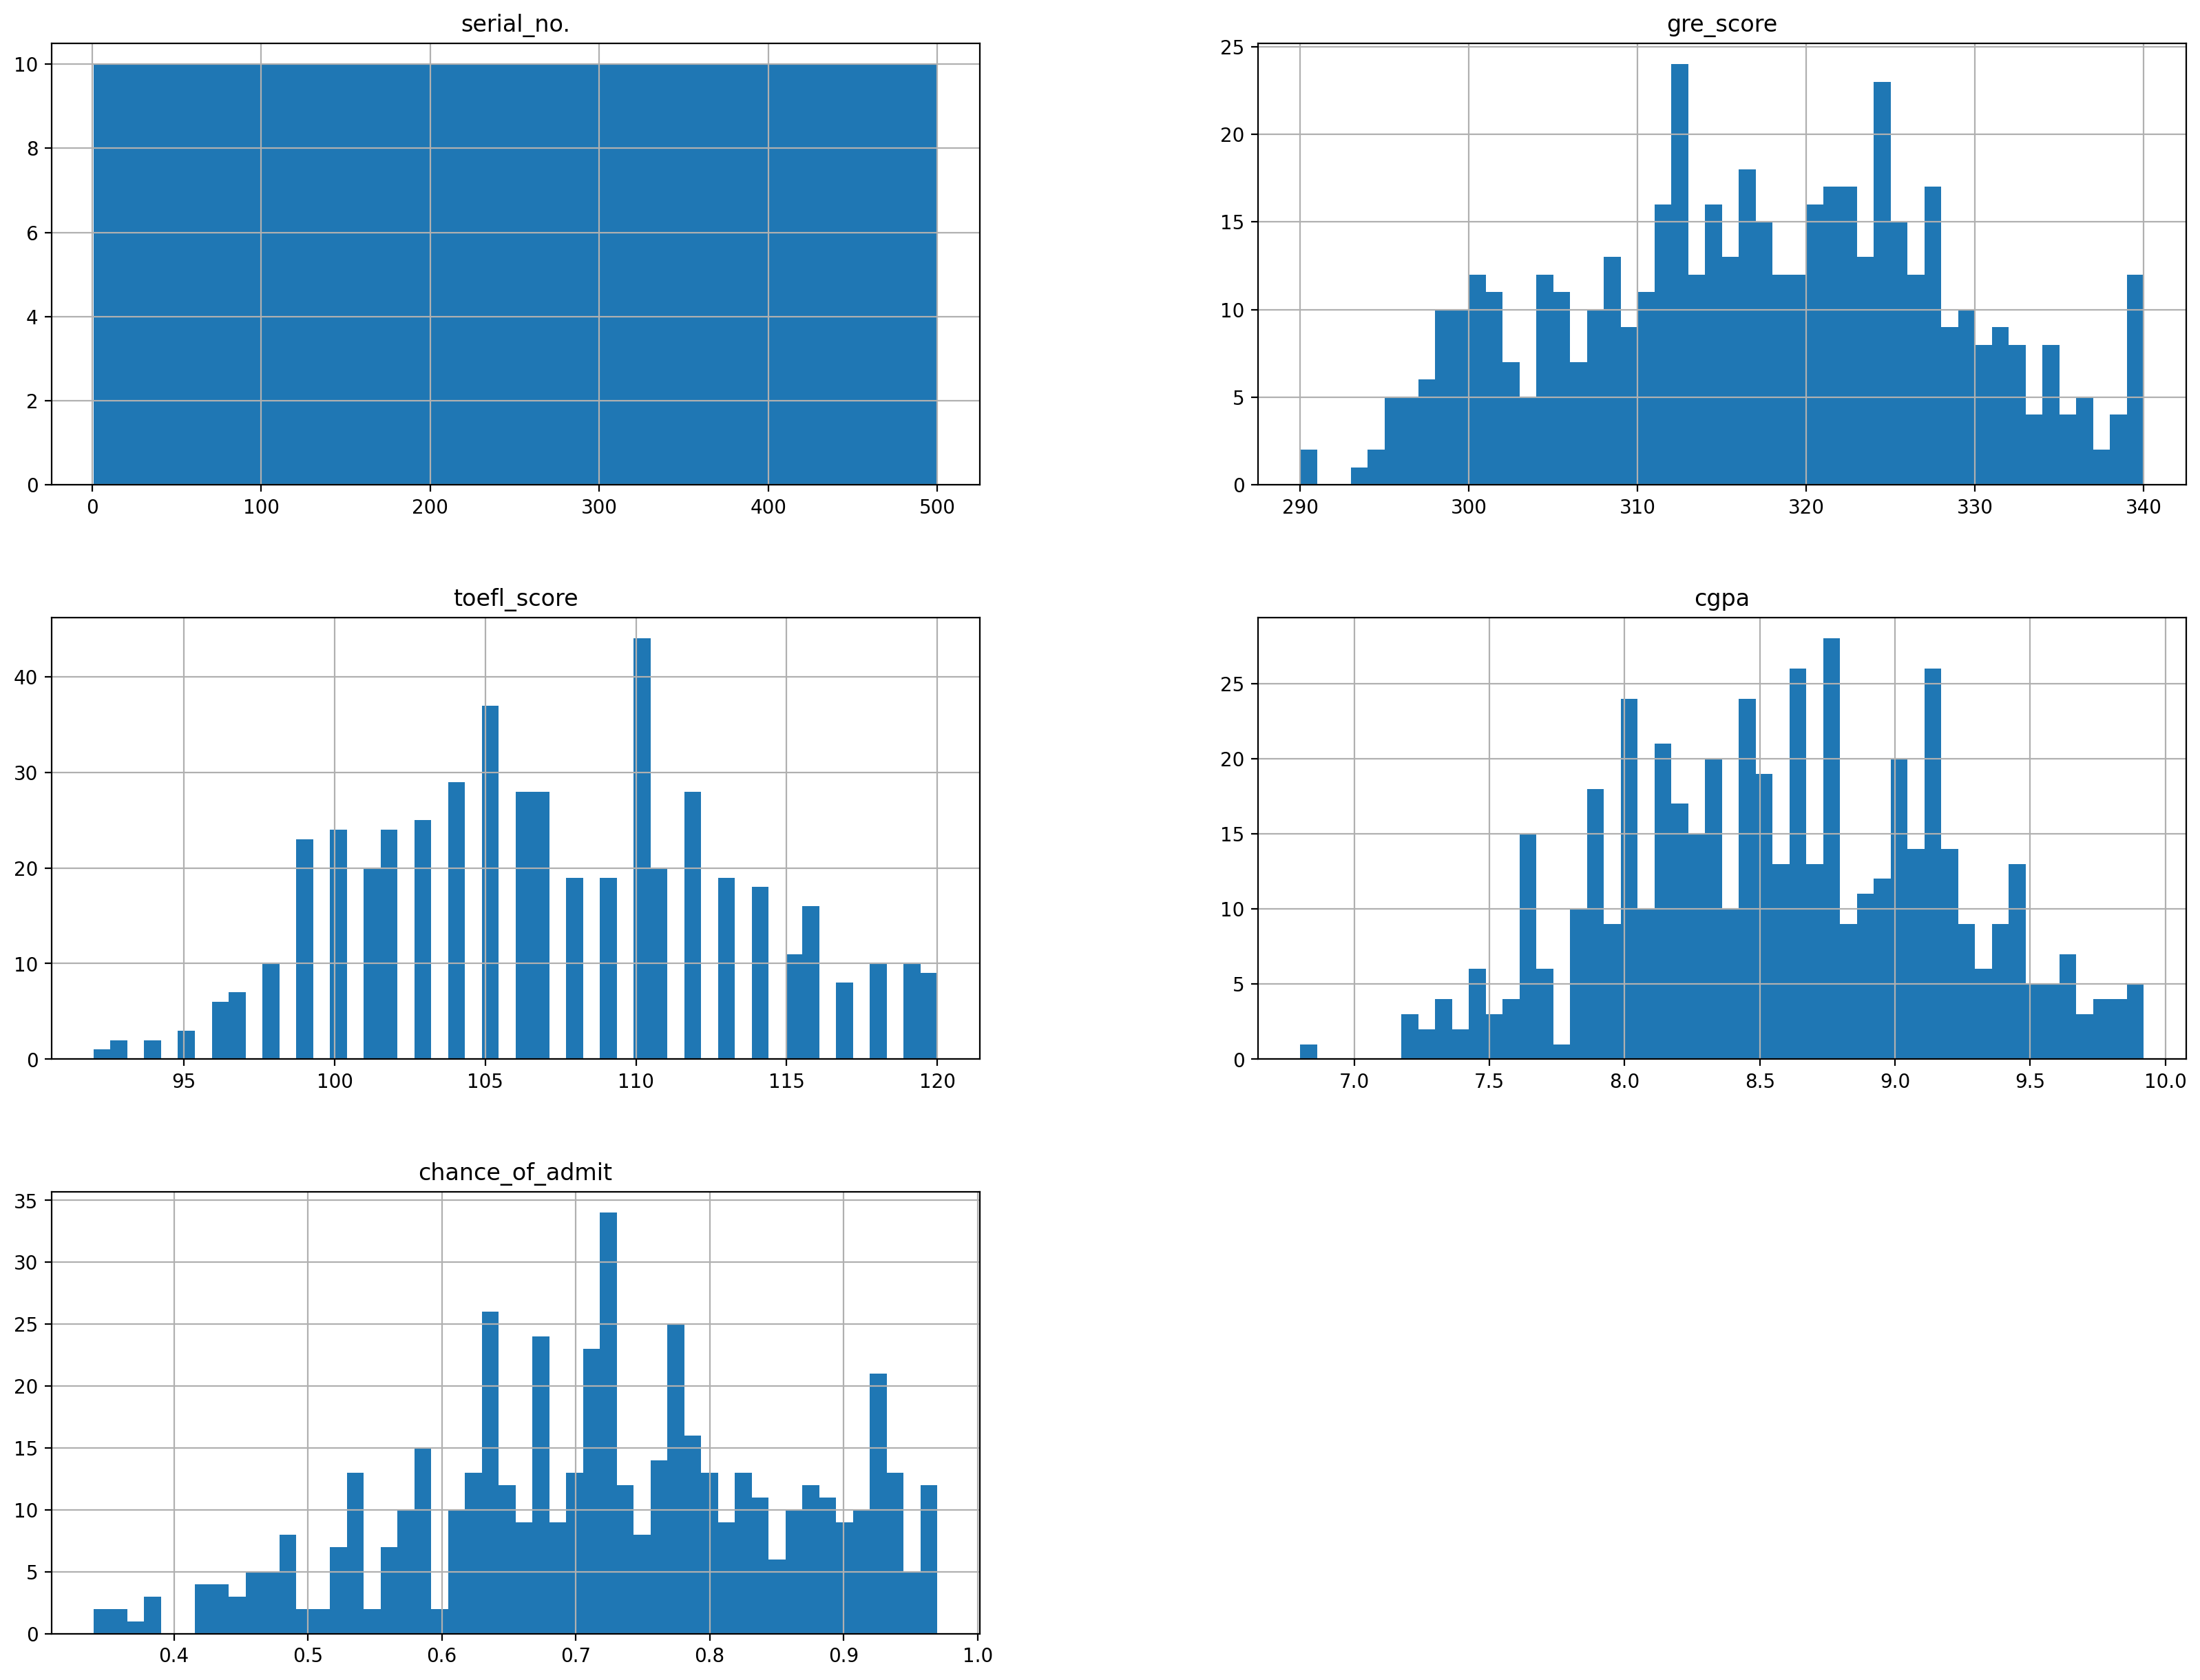

In [61]:
# checking the distribution of all variables
cleaned_df.hist(bins=50, figsize=(20,15))
plt.show()

In [62]:
cleaned_df.iloc[3,4] = np.nan
cleaned_df.iloc[2,5] = np.nan
cleaned_df

,serial_no.,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,NaN,8.00,1,0.72
3,4,322,110,3,NaN,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,332,108,5,4.5,4.0,9.02,1,0.87
496,497,337,117,5,5.0,5.0,9.87,1,0.96
497,498,330,120,5,4.5,5.0,9.56,1,0.93
498,499,312,103,4,4.0,5.0,8.43,0,0.73


In [63]:
from sklearn.impute import SimpleImputer

mean_inpute = SimpleImputer(strategy='median')
mean_inpute.set_output(transform="pandas")
df_imputed = mean_inpute.fit_transform(cleaned_df)

df_imputed


,serial_no.,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
0,1.0,337.0,118.0,4.0,4.5,4.5,9.65,1.0,0.92
1,2.0,324.0,107.0,4.0,4.0,4.5,8.87,1.0,0.76
2,3.0,316.0,104.0,3.0,3.0,3.5,8.00,1.0,0.72
3,4.0,322.0,110.0,3.0,3.5,2.5,8.67,1.0,0.80
4,5.0,314.0,103.0,2.0,2.0,3.0,8.21,0.0,0.65
...,...,...,...,...,...,...,...,...,...
495,496.0,332.0,108.0,5.0,4.5,4.0,9.02,1.0,0.87
496,497.0,337.0,117.0,5.0,5.0,5.0,9.87,1.0,0.96
497,498.0,330.0,120.0,5.0,4.5,5.0,9.56,1.0,0.93
498,499.0,312.0,103.0,4.0,4.0,5.0,8.43,0.0,0.73


# Data Transformation
* Add promising transformations of features (e.g., log(x), sqrt(x), x^2, etc.) to remove the skewness 
* Feature scaling for numerical data
	1. Standardization (Z-Score Normalization)
		- When to Use: When the data is normally distributed or when the algorithm assumes normality.
		- Pros: Makes assumptions about the data being normally distributed.
		- Cons: Not suitable for data that is not normally distributed.
	2. Min-Max Scaling
		- When to Use: When the algorithm does not assume any specific distribution of the input data.
		- Pros: Useful for algorithms that do not assume a particular distribution.
		- Cons: Does not handle outliers well.
	3. Robust Scaling
		- When to Use: When the data contains outliers.
		- Pros: Handles outliers better than standardization and min-max scaling.
		- Cons: May not be suitable for algorithms that require the data to be normally distributed.
**Choosing the Right Method**
The choice of feature scaling method depends on the nature of your data and the requirements of your machine learning model. 
**Data Distribution**: If your data is normally distributed, standardization might be the best choice. If the data contains outliers, robust scaling could be more appropriate.
**Algorithm Requirements**: Some algorithms, like linear regression, assume that the data is normally distributed, making standardization a good fit. Other algorithms, like k-nearest neighbors (KNN), do not make such assumptions and might benefit from min-max scaling.
**Outliers**: If your dataset contains outliers, robust scaling can help mitigate their impact on the model's performance.

* Encode categorical data 
	* `OrdinalEncoder()` => only if categories are ordinal like bad, avg, good
	* `OneHotEncoder()` => if not ordinal or if distance between ordinal categories are not same and outputs as SciPy sparse matrix,  (stores cat details in feature_names_in_ attribute)

In [80]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder


# Column Transformer
from sklearn.compose import make_column_transformer, make_column_selector



ct = make_column_transformer(
    (   # Numerical Pipeline => SimpleImputer + StandardScaler
        make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), 
        make_column_selector(dtype_include=np.number)
    ),
    
    (   # Categorical Pipeline => SimpleImputer + OrdinalEncoder
        make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder()), 
        make_column_selector(dtype_exclude=np.number)
    ),
    n_jobs=-1,
    verbose=True
)


In [73]:
# Stationary Pipeline

stationry_pipeline = ct
ct.set_output(transform="pandas")


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ca1a9c23110>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ca1a9acf8d0>)])

In [75]:
df = ct.fit_transform(X_train)
df

pipeline-2__lor
3.0    74
4.0    64
5.0    60
6.0    43
7.0    35
2.0    33
1.0    31
0.0    10
Name: count, dtype: int64

# Pipeline II : Feature Engineering Pipeline
* Only applies to the feature variable

# Feature Generation
  > this is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step
- Drop the attributes that provide no useful information for the task. 
- New Feature by changing reference point 
    - Example: Create a new feature 'delivery_time' as the difference between 'delivery_date' and 'purchase_date'.
- Granulize and de granulize values 
    - Granulizing
        - GDP per captia from GDP
        - Find average consumption of each district from state consumption by taking ratio of state consumption / no. of districts 
    - Aggregate by grouping some important variables like cust_id or district, university, etc.
        -  Sum up the value of each district to get the state consumption => for better understanding divide it by no of state to get average district spending for that state
        - average or AOV for each customer group => we can know how much a customer is purchasing on average 
- Discretize continuous features (above is better because there we are binning with a variable of interest)
    - Categorize to bins such that no bin has very less values
- Combine 2 variables to capture their relationship 
    - See what happens to x\*y or x/y etc with this https://www.desmos.com/
    - if income is x and y is income then y/x => lesser age people with high income will be rewarded more  <= inverse relation with age and direct with income 
    - if x\*y => younger people with more income or older people with less income will be more rewarded (x and y have direct relationship)
- Decompose features (e.g., categorical, date/time, etc.).
    - Example: the day of the week, month, or season to capture patterns
- Check for categories with very low counts (which may need to be grouped or removed).
    - Example: Group infrequent 'product_category' values into an 'Other' category, collapse 'single', 'unmarried', 's'
- [ ]  Data Leakage: Ensure that future information is not inadvertently included in the training data (especially relevant for time series or predictive modeling).
    - Example: In a predictive model for stock prices, ensure that future stock prices are not included in the training data.

In [ ]:
# Drop serial_no column
# gre sqr, uni sqr, gre/uni 
# grp by uni rating and agg sum of gre, toefl, cgpa


# Visualisation and Exploration
* convert pipeline output to pd.DataFrame